# Deporvillage use case

---
**OPTION 1**: Predict Quantity at Brand + Family Level, then Convert to Revenue  

1.	Aggregate historical quantity sold at (brand, family, date).
2.	Predict total quantity for the future period. Target Variable: total_quantity per brand/family for the forecast period.
3.	Convert to revenue using an estimated PVP per (brand, family), such as a Weighted PVP based on sales distribution:
$$\text{avg\_pvp} = \frac{\sum (\text{quantity} \times \text{pvp})}{\sum \text{quantity}}$$



- Pros:  
	•	More granular, allowing adjustments based on price changes.  
	•	If PVP changes, we can easily recalculate revenue.  

- Cons:  
	•	Requires an extra step and assumes PVP remains constant or follows a simple trend.    

This is probably better is PVP fluctuates.  

---
**OPTION 2**: Directly Predict Revenue (Sales)  

Target Variable: $\text{total revenue} = \text{total quantity sold} × PVP$  

1.	Aggregate historical revenue at (brand, family, date).
2.	Predict total revenue for the future period. 

- Pros:  
	•	Simpler approach with fewer calculations.
	•	Directly aligns with the budgeting goal.  
    •   No need to worry about varying PVP within a brand + family.

- Cons:  
	•	If prices fluctuate, the model won’t capture it properly.  
	•	Less flexibility—harder to analyze quantity vs. price effects separately.  

Assumes PVP is stable.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")

In [16]:
df_products

,product_id,seasonality,brand,family,pvp
0,B62548492337415883ABC8AED96D200D,N-A,Columbia,Botas de montaña,34.99
1,EAF768F4315E469FA2E87DD7DF1E756C,N-A,Columbia,Zapatillas de montaña,24.99
2,97200233B9124C039682341F902D1C84,FS,Columbia,Chanclas Urban,24.99
3,141AF4A35EA7400E90A7B38BBC2F742E,FS,Columbia,Chanclas Urban,12.99
4,02EE0C8C1CC4437595499F6DA329BC36,FS,Columbia,Sandalias,49.95
...,...,...,...,...,...
19363,7F0AAC1D8C4143A39CEA9120DD166465,W,Columbia,Chaquetas Outdoor,45.00
19364,F00E54745F854E99A8E6BB9151406CFE,M,Columbia,Chaquetas Outdoor,40.00
19365,9F920D6E8D034844A9179B0238B7D0D8,M,Columbia,Chaquetas Outdoor,45.00
19366,CD4E9156E0214BFFB9E9976C4AD7C0EB,W,Columbia,Forros polares Outdoor,40.00


In [17]:
df = df_sales.merge(df_products, on="product_id")

df = df.rename(columns={"fecha": "date"})
df['date'] = pd.to_datetime(df['date'])

# Aggregate sales to Brand + Family Level
df_grouped = df.groupby(['brand', 'family', 'date']).agg(
    total_quantity=('quantity', 'sum'), 
    total_revenue=('quantity', lambda x: np.sum(x * df.loc[x.index, 'pvp'])) # Weighted revenue
).reset_index()

# Compute average weighted PVP per brand+family
df_grouped['avg_pvp'] = df_grouped['total_revenue'] / df_grouped['total_quantity']

In [39]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

<Axes: xlabel='year,month'>

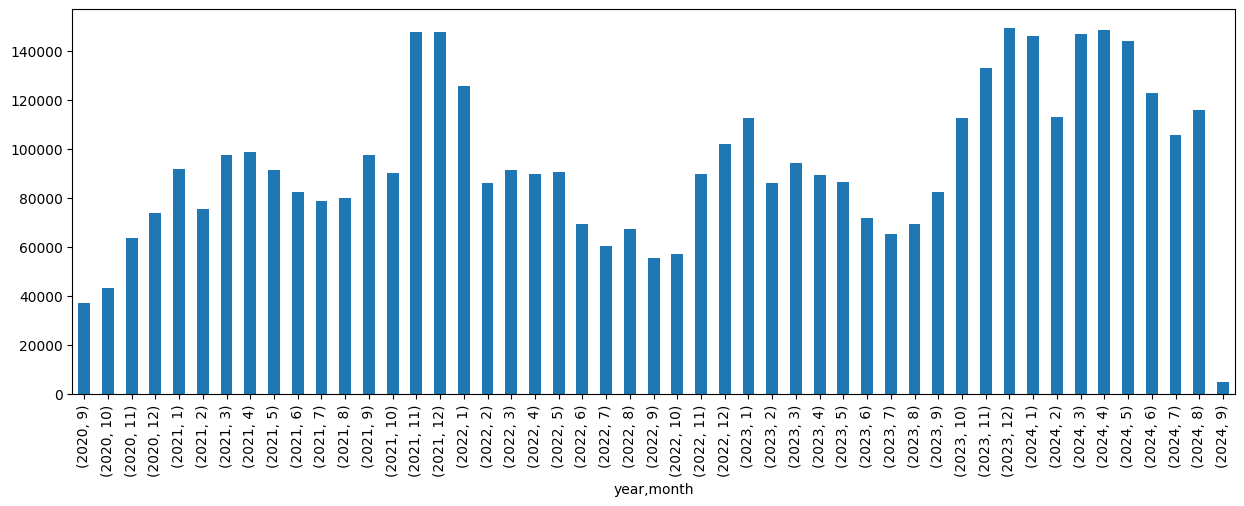

In [40]:
df.groupby(['year', 'month'])['pvp'].sum().plot(kind='bar', figsize=(15, 5))

In [18]:
# All products have a unique PVP, seasonality, brand and family (as expected)
assert (df.groupby('product_id')['pvp'].nunique() != 1).sum() == 0
assert (df.groupby('product_id')['seasonality'].nunique() != 1).sum() == 0
assert (df.groupby('product_id')['brand'].nunique() != 1).sum() == 0
assert (df.groupby('product_id')['family'].nunique() != 1).sum() == 0

In [19]:
df.head()

,product_id,date,store,quantity,seasonality,brand,family,pvp
0,883A4A2507184C5483FDC9FC7E48240B,2021-03-22,FR,1.0,N-A,adidas,Zapatillas Trail Running,130.0
1,883A4A2507184C5483FDC9FC7E48240B,2021-03-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.0
2,883A4A2507184C5483FDC9FC7E48240B,2021-08-27,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.0
3,883A4A2507184C5483FDC9FC7E48240B,2021-06-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.0
4,883A4A2507184C5483FDC9FC7E48240B,2021-03-05,IT,1.0,N-A,adidas,Zapatillas Trail Running,130.0


In [20]:
df.groupby(['family', 'brand'])['seasonality'].nunique()

family                 brand   
Bañadores Natación     Columbia    1
                       adidas      3
Bañadores Urban        adidas      1
Botas Urban            Columbia    1
                       adidas      1
                                  ..
Zapatillas Urban       Columbia    1
                       adidas      1
Zapatillas de montaña  Columbia    1
                       adidas      2
Zuecos Urban           adidas      1
Name: seasonality, Length: 109, dtype: int64

In [21]:
df.groupby(['family', 'brand'])['store'].nunique()

family                 brand   
Bañadores Natación     Columbia     2
                       adidas      20
Bañadores Urban        adidas       3
Botas Urban            Columbia     2
                       adidas       2
                                   ..
Zapatillas Urban       Columbia     5
                       adidas      25
Zapatillas de montaña  Columbia    11
                       adidas      20
Zuecos Urban           adidas       5
Name: store, Length: 109, dtype: int64

In [22]:
df.groupby(['family'])['seasonality'].nunique()

family
Bañadores Natación             3
Bañadores Urban                1
Botas Urban                    1
Botas de montaña               2
Calcetines Running             1
                              ..
Zapatillas Training            1
Zapatillas Triatlón running    1
Zapatillas Urban               1
Zapatillas de montaña          2
Zuecos Urban                   1
Name: seasonality, Length: 82, dtype: int64

In [23]:
df['brand'].value_counts()

brand
adidas      51378
Columbia    11436
Name: count, dtype: int64

In [24]:
df[['brand', 'family']].nunique()

brand      2
family    82
dtype: int64

In [25]:
df['seasonality'].value_counts()

seasonality
N-A    44947
M       7885
W       5330
FW      1941
S       1841
FS       870
Name: count, dtype: int64

In [26]:
df['seasonality'].unique()

array(['N-A', 'M', 'W', 'FW', 'S', 'FS'], dtype=object)

In [27]:
df['family'].value_counts()

family
Zapatillas Urban              12373
Zapatillas Running             9696
Chaquetas Outdoor              5435
Zapatillas de montaña          5342
Zapatillas Trail Running       3453
                              ...  
Culotes Ciclismo                  2
Headwear Training                 2
Outlet Zapatillas Ciclismo        1
Headwear Running                  1
Maillots Ciclismo                 1
Name: count, Length: 82, dtype: int64

In [28]:
df['store'].value_counts()

store
ES    36300
FR     8795
DE     6289
PT     4929
IT     4318
GB      552
US      233
BE      229
NL      215
DK      157
IE      140
AT      126
AU       84
CA       81
CH       65
PL       64
CL       49
SE       35
LU       29
SA       27
CO       19
CY       16
DZ        8
CZ        8
LT        7
SI        7
MT        6
NO        5
GR        4
HR        4
RO        3
TN        2
HU        2
AO        2
RE        1
MX        1
SK        1
AR        1
Name: count, dtype: int64

In [29]:
df['family'].value_counts().head(20)

family
Zapatillas Urban                12373
Zapatillas Running               9696
Chaquetas Outdoor                5435
Zapatillas de montaña            5342
Zapatillas Trail Running         3453
Calcetines Running               2478
Chándales Urban                  2045
Botas de montaña                 1936
Mallas y pantalones Training     1551
Camisetas Training               1504
Camisetas Running                1418
Forros polares Outdoor           1307
Sudaderas Urban                  1222
Outlet Calzado de montaña        1187
Pantalones Urban                 1146
Pantalones Outdoor               1026
Mallas y pantalones Running       885
Camisetas Outdoor                 868
Camisetas Urban                   861
Bañadores Natación                693
Name: count, dtype: int64

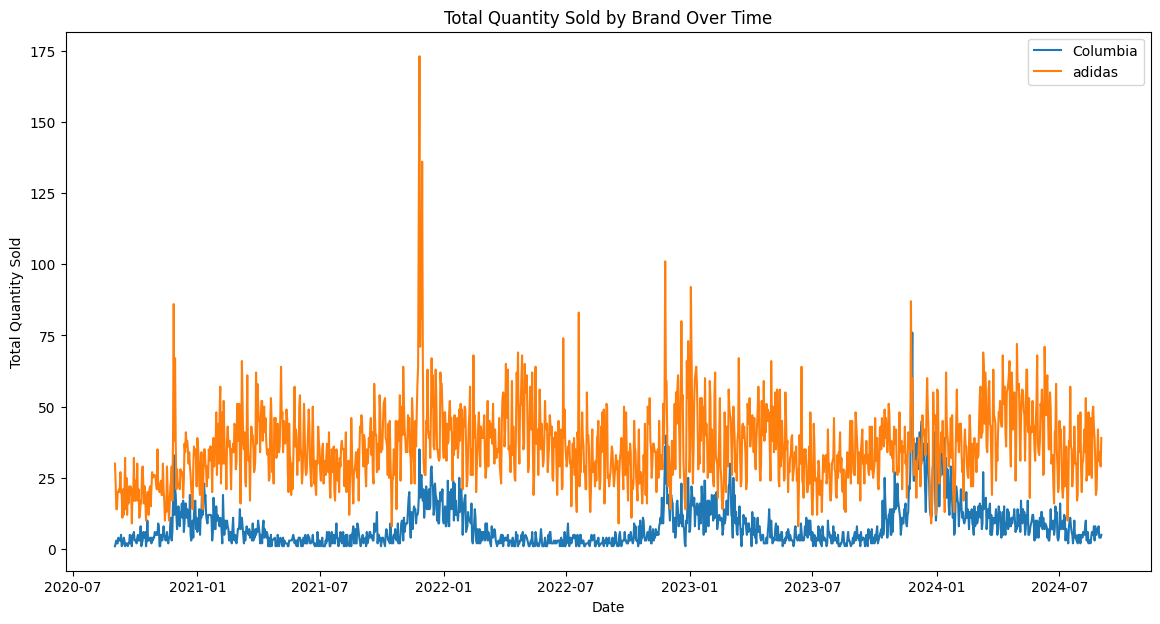

In [30]:
# Aggregate sales to Brand Level
df_brand_grouped = df.groupby(['brand', 'date']).agg(
    total_quantity=('quantity', 'sum'), 
    total_revenue=('quantity', lambda x: np.sum(x * df.loc[x.index, 'pvp'])) # Weighted revenue
).reset_index()

# Plot the time series for total quantity sold by brand
plt.figure(figsize=(14, 7))
for brand in df_brand_grouped['brand'].unique():
    brand_data = df_brand_grouped[df_brand_grouped['brand'] == brand]
    plt.plot(brand_data['date'], brand_data['total_quantity'], label=brand)

plt.title('Total Quantity Sold by Brand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.show()

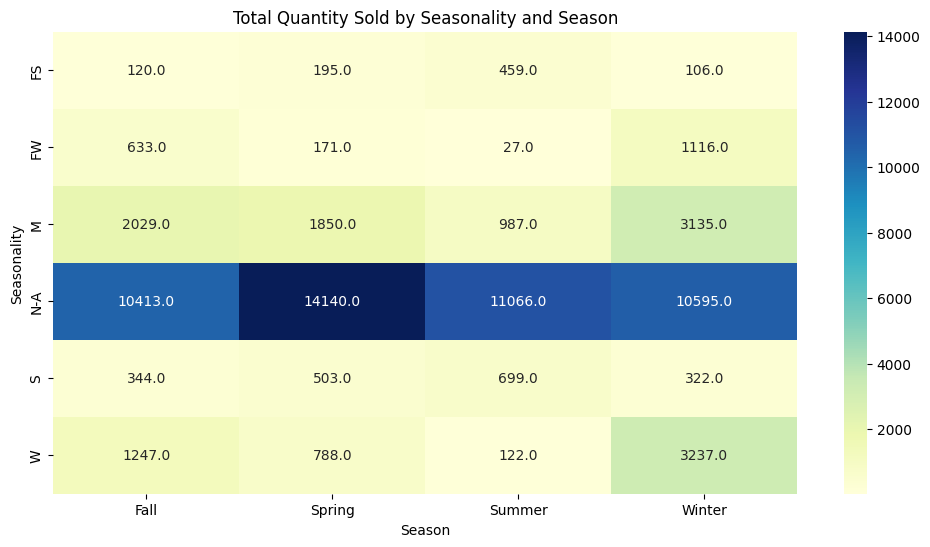

In [31]:
# Extract month from the date
df['month'] = df['date'].dt.month

# Map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Group by seasonality and season to get total quantity sold
seasonality_sales = df.groupby(['seasonality', 'season']).agg(total_quantity=('quantity', 'sum')).reset_index()

# Pivot the data for better visualization
seasonality_sales_pivot = seasonality_sales.pivot(index='seasonality', columns='season', values='total_quantity')

# Plot the data
plt.figure(figsize=(12, 6))
sns.heatmap(seasonality_sales_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Total Quantity Sold by Seasonality and Season')
plt.xlabel('Season')
plt.ylabel('Seasonality')
plt.show()

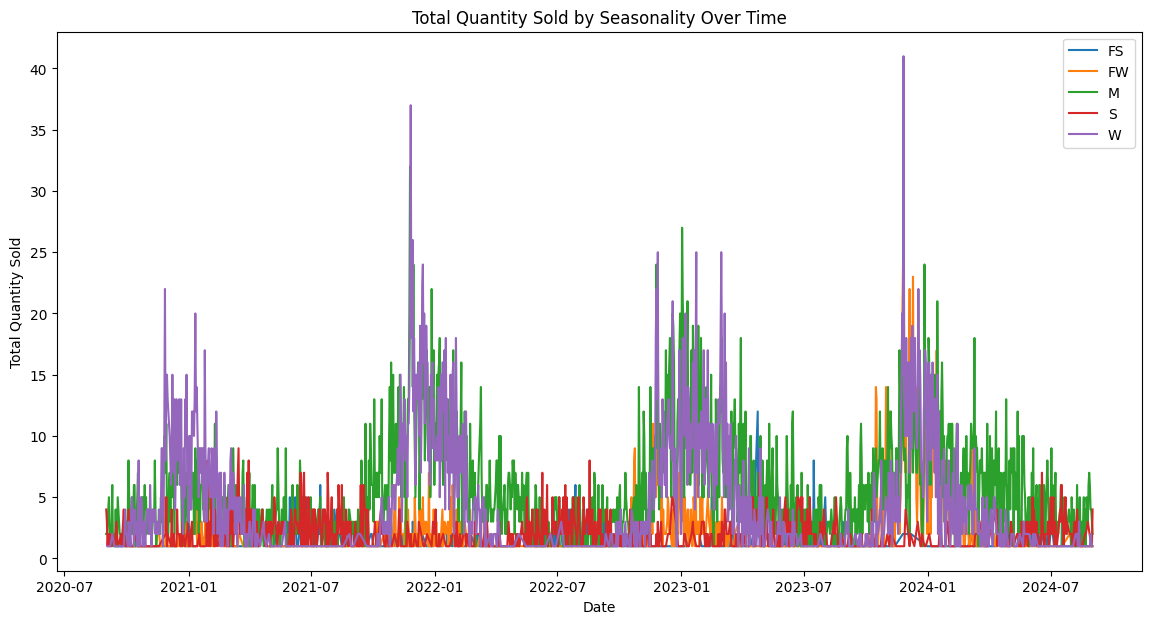

In [32]:
# Aggregate sales to Seasonality Level
df_seasonality_grouped = df.groupby(['seasonality', 'date']).agg(
    total_quantity=('quantity', 'sum'), 
    total_revenue=('quantity', lambda x: np.sum(x * df.loc[x.index, 'pvp'])) # Weighted revenue
).reset_index()

# Plot the time series for total quantity sold by seasonality
plt.figure(figsize=(14, 7))
for seasonality in df_seasonality_grouped['seasonality'].unique():
    if seasonality == 'N-A':
        continue
    seasonality_data = df_seasonality_grouped[df_seasonality_grouped['seasonality'] == seasonality]
    plt.plot(seasonality_data['date'], seasonality_data['total_quantity'], label=seasonality)

plt.title('Total Quantity Sold by Seasonality Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.show()

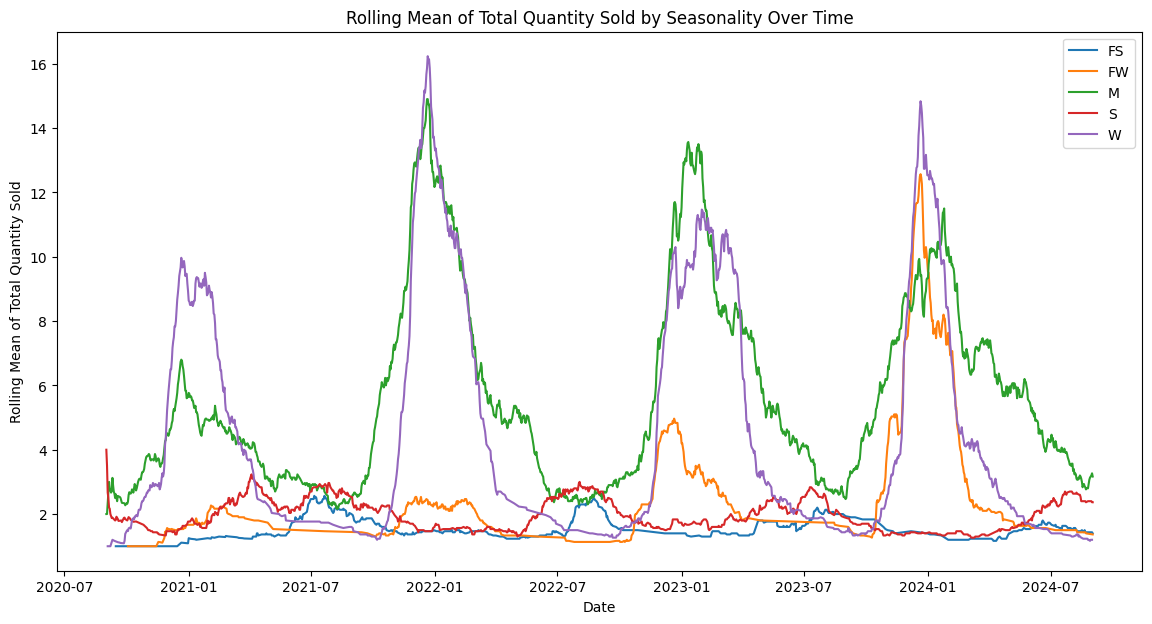

In [33]:
# Calculate the rolling mean with a window of 30 days
df_seasonality_grouped['rolling_mean_quantity'] = df_seasonality_grouped.groupby('seasonality')['total_quantity'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Plot the rolling mean time series for total quantity sold by seasonality
plt.figure(figsize=(14, 7))
for seasonality in df_seasonality_grouped['seasonality'].unique():
    if seasonality == 'N-A':
        continue
    seasonality_data = df_seasonality_grouped[df_seasonality_grouped['seasonality'] == seasonality]
    plt.plot(seasonality_data['date'], seasonality_data['rolling_mean_quantity'], label=seasonality)

plt.title('Rolling Mean of Total Quantity Sold by Seasonality Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Mean of Total Quantity Sold')
plt.legend()
plt.show()

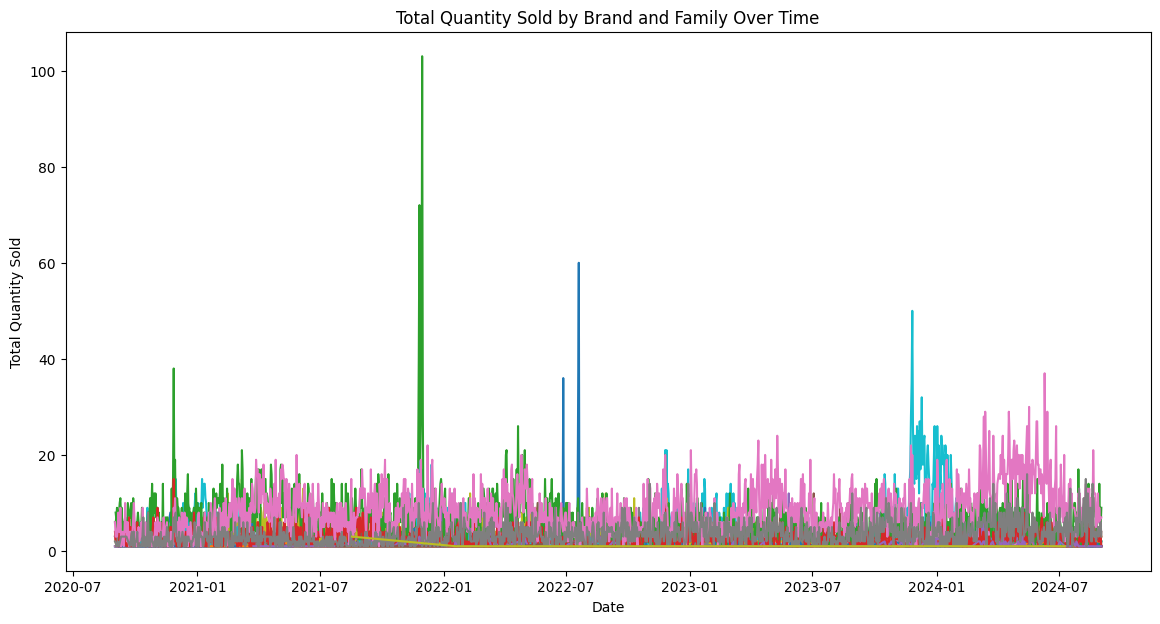

In [34]:
# Aggregate sales to Brand + Family Level
df_brand_family_grouped = df.groupby(['brand', 'family', 'date']).agg(
    total_quantity=('quantity', 'sum'), 
    total_revenue=('quantity', lambda x: np.sum(x * df.loc[x.index, 'pvp'])) # Weighted revenue
).reset_index()

# Plot the time series for total quantity sold by brand and family
plt.figure(figsize=(14, 7))
for (brand, family), group_data in df_brand_family_grouped.groupby(['brand', 'family']):
    plt.plot(group_data['date'], group_data['total_quantity'], label=f'{brand} - {family}')

plt.title('Total Quantity Sold by Brand and Family Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.show()

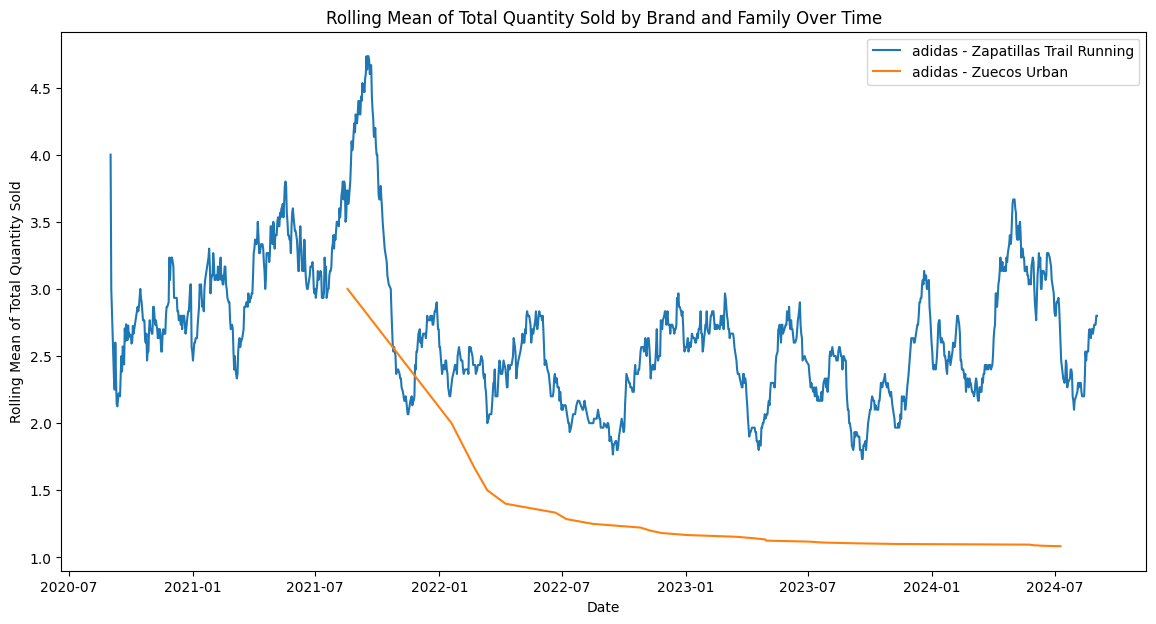

In [35]:
# Aggregate sales to Brand + Family Level
df_brand_family_grouped = df.groupby(['brand', 'family', 'date']).agg(
    total_quantity=('quantity', 'sum'), 
    total_revenue=('quantity', lambda x: np.sum(x * df.loc[x.index, 'pvp'])) # Weighted revenue
).reset_index()

# Calculate the rolling mean with a window of 30 days
df_brand_family_grouped['rolling_mean_quantity'] = df_brand_family_grouped.groupby(['brand', 'family'])['total_quantity'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Plot the rolling mean time series for total quantity sold by brand and family
plt.figure(figsize=(14, 7))
for (brand, family), group_data in df_brand_family_grouped.groupby(['brand', 'family']):
    if brand == 'adidas' and family in ['Zapatillas Trail Running', 'Zuecos Urban']:
        plt.plot(group_data['date'], group_data['rolling_mean_quantity'], label=f'{brand} - {family}')

plt.title('Rolling Mean of Total Quantity Sold by Brand and Family Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Mean of Total Quantity Sold')
plt.legend()
plt.show()

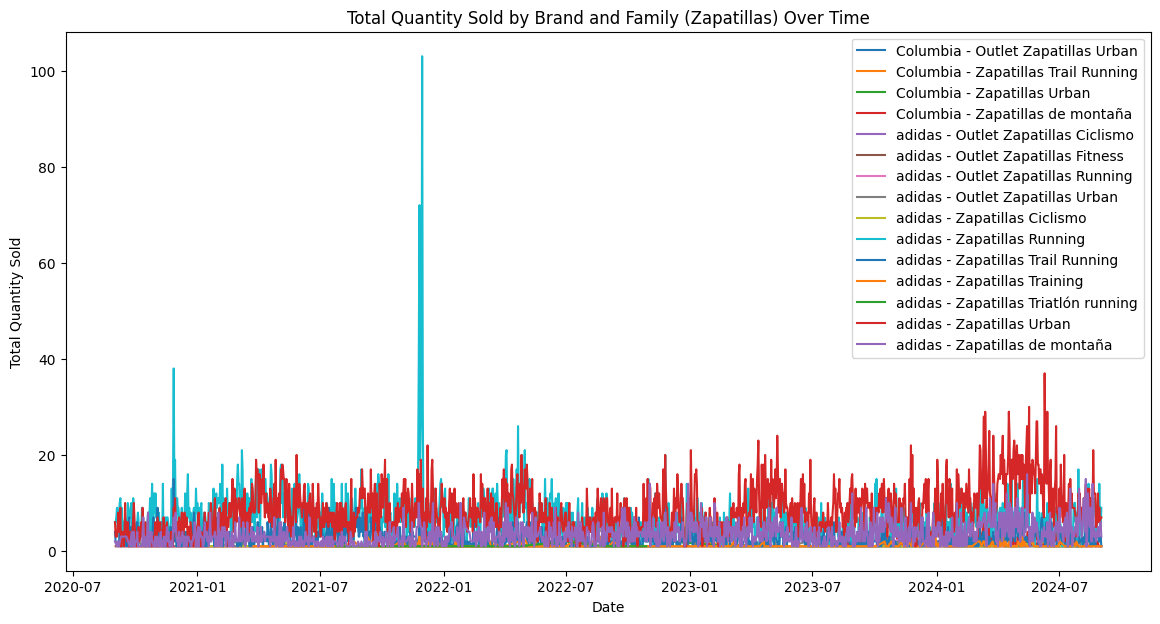

In [36]:
# Filter families with 'Zapatillas' in the name
df_zapatillas = df_brand_family_grouped[df_brand_family_grouped['family'].str.contains('Zapatillas')]

# Plot the time series for total quantity sold by brand and family
plt.figure(figsize=(14, 7))
for (brand, family), group_data in df_zapatillas.groupby(['brand', 'family']):
    plt.plot(group_data['date'], group_data['total_quantity'], label=f'{brand} - {family}')

plt.title('Total Quantity Sold by Brand and Family (Zapatillas) Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.show()

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_13666/3795578736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zapatillas['rolling_mean_quantity'] = df_zapatillas.groupby(['brand', 'family'])['total_quantity'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())


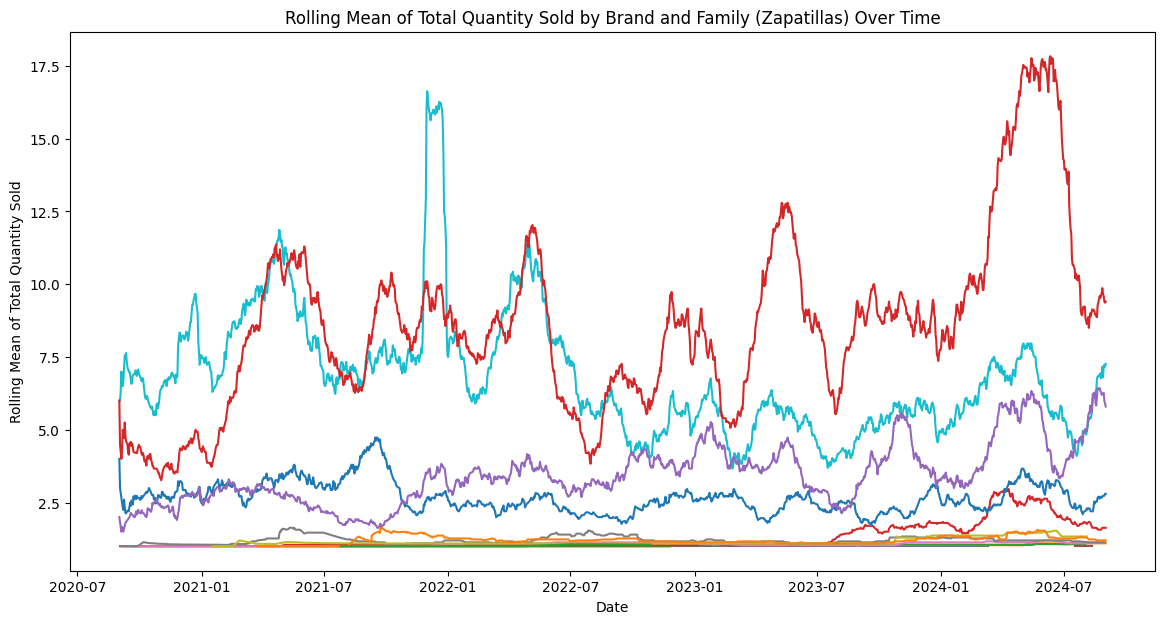

In [37]:
# Calculate the rolling mean with a window of 30 days for 'Zapatillas'
df_zapatillas['rolling_mean_quantity'] = df_zapatillas.groupby(['brand', 'family'])['total_quantity'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Plot the rolling mean time series for total quantity sold by brand and family (Zapatillas)
plt.figure(figsize=(14, 7))
for (brand, family), group_data in df_zapatillas.groupby(['brand', 'family']):
    plt.plot(group_data['date'], group_data['rolling_mean_quantity'], label=f'{brand} - {family}')

plt.title('Rolling Mean of Total Quantity Sold by Brand and Family (Zapatillas) Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Mean of Total Quantity Sold')
# plt.legend()
plt.show()

## First model

In [38]:
df

,product_id,date,store,quantity,seasonality,brand,family,pvp,month,season
0,883A4A2507184C5483FDC9FC7E48240B,2021-03-22,FR,1.0,N-A,adidas,Zapatillas Trail Running,130.00,3,Spring
1,883A4A2507184C5483FDC9FC7E48240B,2021-03-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.00,3,Spring
2,883A4A2507184C5483FDC9FC7E48240B,2021-08-27,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.00,8,Summer
3,883A4A2507184C5483FDC9FC7E48240B,2021-06-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.00,6,Summer
4,883A4A2507184C5483FDC9FC7E48240B,2021-03-05,IT,1.0,N-A,adidas,Zapatillas Trail Running,130.00,3,Spring
...,...,...,...,...,...,...,...,...,...,...
62809,F438E725631D4B72819E4B2E567B7C14,2023-03-29,ES,1.0,N-A,Columbia,Zapatillas de montaña,99.95,3,Spring
62810,70732AD67F17451387FC89F1E576A525,2021-07-05,ES,1.0,N-A,Columbia,Zapatillas de montaña,80.00,7,Summer
62811,622EF83B0C284654A91A8DBFD176471D,2021-07-10,FR,1.0,N-A,Columbia,Zapatillas de montaña,74.95,7,Summer
62812,8349E74BA6BC4940A06DBD3088332A4C,2023-03-03,ES,1.0,N-A,Columbia,Zapatillas de montaña,35.00,3,Spring
